In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import astropy
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.time import Time
from astropy.constants import G, M_sun
import glob
import os
import duckdb
import sqlutilpy as sqlutil
import gc
from astroquery.gaia import Gaia
from scipy.stats.distributions import chi2
import thejoker as tj
from schwimmbad import MultiPool
import pymc as pm
from pymc_ext.distributions import angle
import multiprocessing as mp
from corner import corner
import arviz

In [2]:
def quality_cuts(file):
    # open file and get data
    hdul = fits.open(file)
    rvtab = hdul[1].data
    fibermap = hdul[2].data
    gaia = hdul[4].data
    
    # convert to astropy tables
    rvtab = Table(rvtab)
    fibermap = Table(fibermap)
    gaia = Table(gaia)
    
    # add necessary columns from FIBERMAP and GAIA to data, following Orbit Fitting Tutorial
    rvtab['MJD'] = fibermap['MJD']
    rvtab['SOURCE_ID'] = gaia['SOURCE_ID']
    rvtab['REF_EPOCH'] = gaia['REF_EPOCH']
    rvtab['RA'] = gaia['RA']
    rvtab['DEC'] = gaia['DEC']
    rvtab['RUWE'] = gaia['RUWE']
    rvtab['PARALLAX'] = gaia['PARALLAX']
    rvtab['PARALLAX_ERROR'] = gaia['PARALLAX_ERROR']
    
    # remove unnecessary RVTAB columns, following Orbit Fitting Tutorial
    unnecessary_columns = [
        'VRAD_SKEW', 'VRAD_KURT', 'TEFF', 'ALPHAFE',
        'LOGG_ERR', 'TEFF_ERR', 'ALPHAFE_ERR', 'FEH_ERR',
        'VSINI', 'CHISQ_TOT', 'CHISQ_C_TOT', 'CHISQ_B',
        'CHISQ_C_B', 'CHISQ_R', 'CHISQ_C_R', 'CHISQ_Z',
        'CHISQ_C_Z', 'FIBER', 'REF_ID', 'REF_CAT',
        'TARGET_RA', 'TARGET_DEC', 'TARGETID', 'EXPID'
    ]
    rvtab.remove_columns(unnecessary_columns)
    
    # apply filters
    gaia_id = gaia['SOURCE_ID'] != -9999 #sources with GAIA source IDs (null = -9999)
    spectype = rvtab['RR_SPECTYPE'] == 'STAR' #spectral type is star
    rvs_success = rvtab['SUCCESS'] == True #no RVS warnings
    sn_b = rvtab['SN_B'] > 2 #signal-to-noise ratio > 2
    sn_r = rvtab['SN_R'] > 2 #signal-to-noise ratio > 2
    sn_z = rvtab['SN_Z'] > 2 #signal-to-noise ratio > 2
    v_err = rvtab['VRAD_ERR'] < 20 #velocity uncertainty < 20
    
    # combining all filters to create new dataset
    filter = gaia_id & spectype & rvs_success & sn_b & sn_r & sn_z & v_err
    filtered_data = rvtab[filter]
    
    #close file
    hdul.close()
    
    return filtered_data

In [3]:
# path to folder containing the files
path = '/Users/aishanichaudhuri/Desktop/CTA200H/My Work/Project/DESI DR1'

# initialising and creating dataframes for each file
df_list = []

for file in glob.glob(os.path.join(path, '*.fits')):
    filtered_data = quality_cuts(file)
    df = filtered_data.to_pandas()
    df_list.append(df)

# number of unique stars and epochs in each file
unique_stars = []
epoch = []

for df in df_list:
    unique_stars.append(df['SOURCE_ID'].nunique())
    epoch.append(len(df))
    
# creating a comprehensive dataframe and finding number of unique stars and epochs
filtered_df = pd.concat(df_list, ignore_index=True)
unique_stars_all = filtered_df['SOURCE_ID'].nunique()
epoch_all = len(filtered_df)

In [5]:
# create database
conn1 = duckdb.connect(':memory:')
conn1.register('repeats0', filtered_df)
conn1.execute('create table repeats as select * from repeats0')
conn1.execute('create index qq on repeats(source_id)')

# query database for repeats and summarise
results = sqlutil.get(
    f'''
with x as (
    select source_id, count(*) as n_repeats from repeats 
    group by source_id
)
select 
    x.source_id,
    min(ra) as ra,
    min(dec) as dec,
    count(*) as n_repeats,
    max(mjd) - min(mjd) as dmjd,
    min(vrad) as min_vrad,
    max(vrad) as max_vrad,
    max(vrad) - min(vrad) as diffvrad,
    max(vrad_err) as max_vrad_err,
    stddev_pop(vrad) as vrad_std,
    avg(feh) as feh,
    avg(logg) as logg,
    min(parallax) as parallax,
    min(parallax_error) as parallax_error,
    min(ruwe) as ruwe
from repeats as r, x
    where x.source_id = r.source_id
group by x.source_id
''',
    conn=conn1,
    driver='duckdb',
    asDict=True
)

# reformat results

for _ in ['parallax','parallax_error']:
    results[_]=results[_].astype(float)
obs_count_df = Table(results).to_pandas()
obs_count_df.index = obs_count_df['SOURCE_ID']
filtered_df.index = filtered_df['SOURCE_ID']
obs_count_df.sort_index(inplace=True)

gc.collect()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

0

In [6]:
obs_count_df

,SOURCE_ID,ra,dec,n_repeats,dmjd,min_vrad,max_vrad,diffvrad,max_vrad_err,vrad_std,feh,logg,parallax,parallax_error,ruwe
SOURCE_ID,,,,,,,,,,,,,,,
4295806720,4295806720,44.996155,0.005615,1,0.000000,-41.574680,-41.574680,0.000000,1.187289,0.000000,-0.839495,4.933432,0.354331,0.122664,1.142952
828929527040,828929527040,45.023620,0.068419,1,0.000000,17.398664,17.398664,0.000000,0.420159,0.000000,-0.081240,4.655942,1.203095,0.066816,1.034901
2336462213888,2336462213888,45.104664,0.098517,1,0.000000,-116.330831,-116.330831,0.000000,4.074359,0.000000,-1.134647,4.332482,0.373936,0.236391,0.974292
5295694864384,5295694864384,44.925444,0.149559,5,92.759349,0.082861,7.455364,7.372503,2.707248,2.715102,-2.282742,1.460209,NaN,NaN,None
5497558205696,5497558205696,44.875392,0.118205,1,0.000000,-2.742482,-2.742482,0.000000,0.457754,0.000000,-0.207252,4.964232,0.712105,0.048858,0.986329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6917528099929998976,6917528099929998976,314.986153,-0.070998,2,244.370287,24.027241,27.674165,3.646924,1.269760,1.823462,-0.432871,4.861028,0.478453,0.104192,1.05734
6917528649685818880,6917528649685818880,315.024952,-0.037901,1,0.000000,8.895536,8.895536,0.000000,2.329578,0.000000,-0.574793,4.831804,0.520860,0.307052,1.000823
6917528718403911424,6917528718403911424,315.030287,-0.026705,1,0.000000,63.493655,63.493655,0.000000,2.078720,0.000000,-0.511434,4.662370,0.617905,0.255204,1.040671


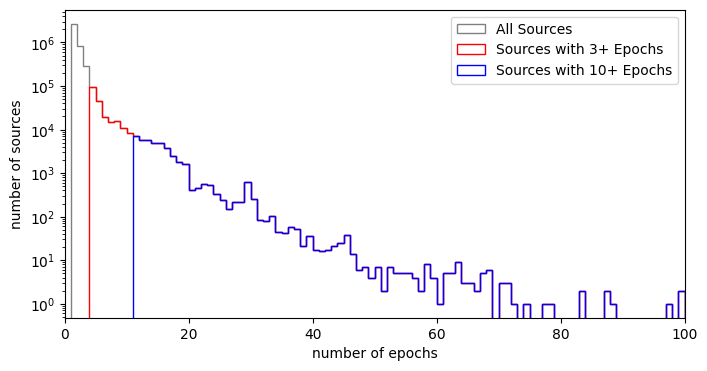

In [7]:
# histogram of epochs

plt.figure(figsize=(8, 4))

plt.hist(
    obs_count_df["n_repeats"],
    bins=np.arange(obs_count_df["n_repeats"].max() + 2),
    color="gray",
    histtype="step",
    label="All Sources",
)

plt.hist(
    obs_count_df.loc[(obs_count_df["n_repeats"] > 3), "n_repeats"],
    bins=np.arange(obs_count_df["n_repeats"].max() + 2),
    color="r",
    histtype="step",
    label="Sources with 3+ Epochs"
)

plt.hist(
    obs_count_df.loc[(obs_count_df["n_repeats"] > 10), "n_repeats"],
    bins=np.arange(obs_count_df["n_repeats"].max() + 2),
    color="b",
    histtype="step",
    label="Sources with 10+ Epochs"
)

plt.yscale("log")
plt.xlabel("number of epochs")
plt.ylabel("number of sources")
plt.xlim(0, 100)
plt.legend()
plt.show()

In [8]:
# number of sources with more than 3 and more than 10 epochs
print((obs_count_df['n_repeats']>3).sum())
print((obs_count_df['n_repeats']>10).sum())

251664
42663


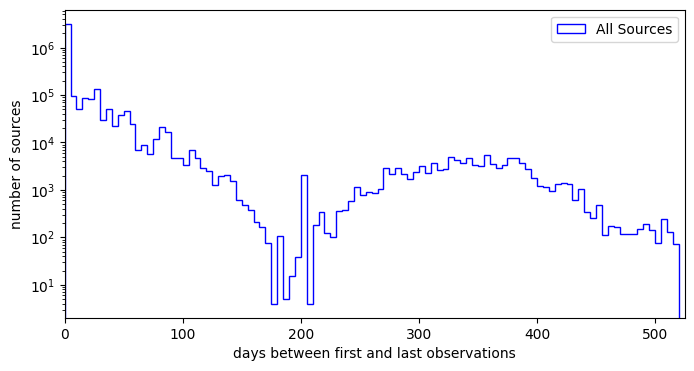

In [9]:
# histogram of number of days between first and last observations

plt.figure(figsize=(8, 4))

plt.hist(
    obs_count_df["dmjd"],
    bins=np.arange(0, obs_count_df["dmjd"].max() + 10, 5),
    color="b",
    histtype="step",
    label="All Sources",
)

plt.yscale("log")
plt.xlabel("days between first and last observations")
plt.ylabel("number of sources")
plt.xlim(0, 525)
plt.legend()
plt.show()

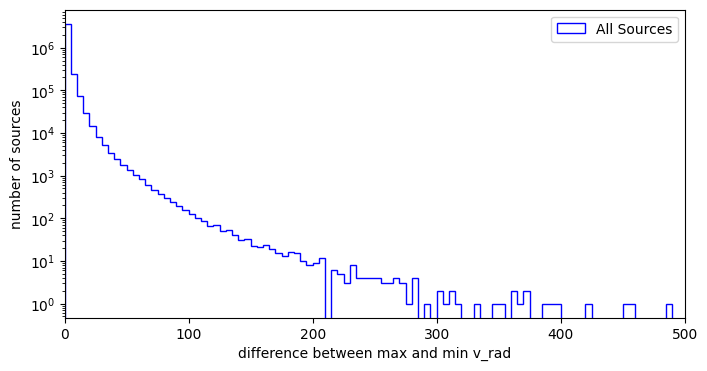

In [10]:
# histogram of difference between max and min vrad

plt.figure(figsize=(8, 4))

plt.hist(
    obs_count_df["diffvrad"],
    bins=np.arange(0, obs_count_df["diffvrad"].max() + 10, 5),
    color="b",
    histtype="step",
    label="All Sources",
)

plt.yscale("log")
plt.xlabel("difference between max and min v_rad")
plt.ylabel("number of sources")
plt.xlim(0, 500)
plt.legend()
plt.show()

In [11]:
# cutting sources with < 3 epochs, following Orbit Fitting Tutorial
morethantwo = obs_count_df['n_repeats'] > 2
obs_count_df = obs_count_df[morethantwo]

filtered_df = filtered_df.loc[
    filtered_df.index.isin(obs_count_df.index)
]

In [12]:
filtered_df

,VRAD,VRAD_ERR,LOGG,FEH,RVS_WARN,SN_B,SN_R,SN_Z,SUCCESS,RR_Z,RR_SPECTYPE,HEALPIX,MJD,SOURCE_ID,REF_EPOCH,RA,DEC,RUWE,PARALLAX,PARALLAX_ERROR
SOURCE_ID,,,,,,,,,,,,,,,,,,,,
2861876553460474112,-262.494924,5.492261,4.493302,-3.212481,0,10.669153,13.093206,12.283287,True,-0.000859,STAR,20334,59475.437149,2861876553460474112,2016.0,2.190586,31.758460,1.002287,0.211156,0.147693
2861876553460474112,-257.049416,2.444948,4.826477,-2.787424,0,22.941086,27.187200,24.771062,True,-0.000859,STAR,20334,59475.442544,2861876553460474112,2016.0,2.190586,31.758460,1.002287,0.211156,0.147693
2861800828892789888,-59.913902,0.998172,4.410328,-0.730339,0,24.620012,28.440430,29.240815,True,-0.000196,STAR,20334,59475.437149,2861800828892789888,2016.0,2.694239,31.307450,0.993683,0.215631,0.075612
2861800828892789888,-59.046206,0.532527,4.483377,-0.737687,0,46.455177,51.965653,52.897838,True,-0.000196,STAR,20334,59475.442544,2861800828892789888,2016.0,2.694239,31.307450,0.993683,0.215631,0.075612
2861568037370442368,-73.371646,2.749755,4.304267,-0.906993,0,10.385955,13.596271,13.636071,True,-0.000256,STAR,20332,59475.437149,2861568037370442368,2016.0,2.231092,30.723559,0.998705,0.150533,0.156359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577768163310861568,6.192568,3.368478,4.237557,-2.378698,0,9.334551,14.362675,16.880882,True,0.000010,STAR,11210,59301.295377,1577768163310861568,2016.0,188.538516,57.640808,1.043543,0.080121,0.103232
1577708858402345344,-196.652773,1.690787,3.800301,-1.488297,0,15.557938,23.416935,26.759787,True,-0.000655,STAR,11210,59301.295377,1577708858402345344,2016.0,189.704183,57.265902,1.009448,-0.015674,0.082937
1577722877175602560,13.701275,1.901870,4.300865,-1.962065,0,15.754175,22.653614,25.725753,True,0.000044,STAR,11210,59301.295377,1577722877175602560,2016.0,189.674221,57.380608,1.004904,0.327566,0.077016


In [13]:
obs_count_df

,SOURCE_ID,ra,dec,n_repeats,dmjd,min_vrad,max_vrad,diffvrad,max_vrad_err,vrad_std,feh,logg,parallax,parallax_error,ruwe
SOURCE_ID,,,,,,,,,,,,,,,
5295694864384,5295694864384,44.925444,0.149559,5,92.759349,0.082861,7.455364,7.372503,2.707248,2.715102,-2.282742,1.460209,NaN,NaN,None
88171384394240,88171384394240,44.483573,0.492869,5,113.719094,-146.945841,-142.305774,4.640067,4.978002,1.689104,-2.429005,4.680777,0.183537,0.169971,1.023611
91534343111552,91534343111552,44.492288,0.594396,4,108.734993,-1.636078,1.619225,3.255304,1.143607,1.170401,-1.066724,4.384208,0.412358,0.081384,1.037686
98754183803776,98754183803776,44.622904,0.710535,3,87.775247,56.408941,58.633603,2.224663,0.637013,0.913718,-0.772629,4.177388,0.263292,0.078222,1.180458
113524575914240,113524575914240,44.932630,0.816017,3,108.734993,-201.867790,-194.834841,7.032949,6.269170,2.896608,-1.791243,4.151037,-0.146922,0.239636,0.883211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6917301531814513280,6917301531814513280,314.434168,-1.279946,3,10.989875,-56.667416,-52.906258,3.761158,1.490219,1.537659,-0.891135,4.424809,0.137701,0.108661,1.00515
6917309537633771264,6917309537633771264,314.642266,-1.151193,3,10.989875,-39.470140,-37.117007,2.353133,1.554404,0.987821,-1.026078,4.045896,0.317128,0.123978,1.050476
6917328950885784704,6917328950885784704,314.218613,-1.247570,3,120.658057,-204.044667,-199.351477,4.693190,3.309014,1.925618,-3.082922,4.588889,0.248202,0.187179,1.003528


In [14]:
import time

def crossmatch(df, chunk_size=10000, sleep_time=1.0):
    """
    Crossmatches a given dataframe with the Gaia DR3 eclipsing binary catalog.

    Parameters:
    - df: dataframe with 'source_id' as index
    - chunk_size: number of source_ids to query per ADQL batch (default: 10,000)
    - sleep_time: delay between queries in seconds (default: 1.0)

    Returns:
    - matched_df: rows in df that are present in gaiadr3.vari_eclipsing_binary.
    """
    
    # get source ids
    source_ids = df['SOURCE_ID'].unique()
    matched_ids = []

    # chunk source_ids to avoid reaching limit
    for i in range(0, len(source_ids), chunk_size):
        chunk = source_ids[i:i+chunk_size]
        ids_str = ",".join(map(str, chunk))
        
        query = f"""
        select source_id
        from gaiadr3.vari_eclipsing_binary
        where source_id in ({ids_str})
        """
        
        try:
            job = Gaia.launch_job_async(query)
            results = job.get_results()
            matched_ids.extend(results['source_id'].tolist())
        except Exception as e:
            print(f"Query failed on chunk {i//chunk_size + 1}: {e}")
        
        time.sleep(sleep_time)  # avoid hitting rate limits

    # filter the original dataframe
    matched_df = df[df['SOURCE_ID'].isin(matched_ids)].copy()

    return matched_df


In [15]:
gaia_crossmatch = crossmatch(obs_count_df)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [16]:
gaia_crossmatch

,SOURCE_ID,ra,dec,n_repeats,dmjd,min_vrad,max_vrad,diffvrad,max_vrad_err,vrad_std,feh,logg,parallax,parallax_error,ruwe
SOURCE_ID,,,,,,,,,,,,,,,
127347807551024384,127347807551024384,38.174278,26.984701,8,23.068044,-62.812803,-3.925180,58.887623,15.613453,17.289853,-0.360747,4.417484,0.191257,0.143006,0.996946
132605637795925120,132605637795925120,35.799889,31.157874,11,2.015202,-144.908221,-118.200009,26.708212,13.673941,7.091001,-0.962546,3.447759,0.285113,0.158516,1.058299
295410427599735296,295410427599735296,22.603010,26.079527,3,49.951978,-82.216704,-16.236058,65.980646,3.918811,29.682941,-1.067955,4.206980,0.044253,0.107116,1.041449
368650889991553408,368650889991553408,10.027513,39.483100,3,0.030165,-14.283957,-11.566545,2.717412,0.590984,1.117579,-0.965508,4.500093,0.272769,0.070273,0.922058
381056473528770688,381056473528770688,8.278246,40.925554,3,0.025264,-94.826389,-73.636367,21.190022,7.090452,8.743238,-1.058060,3.801130,0.173650,0.099148,0.926741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5763588000877548928,5763588000877548928,133.623158,-2.921983,3,109.694612,94.522926,141.913510,47.390585,4.646870,21.472243,-1.324030,4.472319,0.231312,0.112892,1.049928
6336518633661452928,6336518633661452928,227.308341,-2.949446,3,0.028152,-13.269649,8.717495,21.987144,4.729291,9.105029,-0.819851,4.110566,0.304916,0.095882,0.965106
6339334723457874176,6339334723457874176,224.408412,-2.905065,3,62.833342,-46.801241,-6.902302,39.898939,14.888918,16.421486,-2.608595,4.567800,0.006044,0.230059,1.04174


In [ ]:
# number of sources with more than 10 epochs
print((gaia_crossmatch['n_repeats']>10).sum())

# sources with at least 10 epochs
ten_obs_df = gaia_crossmatch[gaia_crossmatch['n_repeats']>10]

ten_obs_df

# source 987861960052782976 chosen; did not pass statistical checks
# source 1434118068653836928 chosen; passed statistical checks

32


,SOURCE_ID,ra,dec,n_repeats,dmjd,min_vrad,max_vrad,diffvrad,max_vrad_err,vrad_std,feh,logg,parallax,parallax_error,ruwe
SOURCE_ID,,,,,,,,,,,,,,,
132605637795925120,132605637795925120,35.799889,31.157874,11,2.015202,-144.908221,-118.200009,26.708212,13.673941,7.091001,-0.962546,3.447759,0.285113,0.158516,1.058299
709160402639093248,709160402639093248,125.709545,31.679584,12,32.864449,20.225663,70.578492,50.352830,2.352032,20.366081,-0.785288,4.334266,0.271505,0.046896,1.058841
829032974235510272,829032974235510272,156.866804,43.295323,11,29.811357,-9.188907,9.213223,18.402130,5.936836,5.875656,-0.922814,4.406235,0.284834,0.048108,1.05295
831194717175722752,831194717175722752,164.107160,47.250966,24,61.994008,-27.335378,1.030749,28.366127,2.413391,7.625755,-0.416186,4.814104,0.858380,0.051483,1.10729
837912733216161920,837912733216161920,168.754648,49.885803,15,30.074246,44.936457,88.208760,43.272303,3.715231,13.776761,-0.870178,4.818810,0.157843,0.038013,0.996411
838745265380398848,838745265380398848,171.478802,51.999052,13,44.690349,-27.696648,50.804582,78.501230,14.223794,19.411611,-1.434023,4.625410,0.304967,0.104230,1.047039
896074871100794112,896074871100794112,114.536994,37.842273,28,98.929201,-69.558303,99.281498,168.839801,4.850261,53.728274,-1.167589,5.255619,0.932034,0.070344,1.005732
896163484865997824,896163484865997824,115.124626,38.088036,27,97.918411,23.190142,30.078559,6.888416,3.356884,1.887167,-0.164954,4.871542,-0.163647,0.292857,4.335014
903272201199953280,903272201199953280,125.626472,33.778881,12,32.864449,-17.162483,-12.851748,4.310734,0.990332,1.310891,-0.093946,4.934321,1.018406,0.368119,3.336224


In [32]:
def nanaverage(arr, weights, axis=None):
    """
    Compute the weighted average while ignoring NaN values.

    Parameters:
    arr (numpy.ndarray): The array of values.
    weights (numpy.ndarray): The array of weights.
    axis (int, optional): The axis along which to compute the average. Default is None.

    Returns:
    float or numpy.ndarray: The weighted average ignoring NaN values.
    """
    # ensure weights are broadcastable to arr
    weights = np.broadcast_to(weights, arr.shape)
    
    # mask the NaN values in arr and corresponding weights
    mask = ~np.isnan(arr)
    masked_arr = np.where(mask, arr, 0)
    masked_weights = np.where(mask, weights, 0)
    
    # compute the weighted sum and the sum of weights
    weighted_sum = np.nansum(masked_arr * masked_weights, axis=axis)
    sum_of_weights = np.nansum(masked_weights, axis=axis)
    
    return weighted_sum / sum_of_weights


def calc_rv_metrics(vel, vel_err):
    mean_vel = nanaverage(vel, weights=1 / vel_err**2)
    n_vel = np.isfinite(vel).sum().astype(float)
    nu = n_vel - 1
    rv_chi2 = nu ** (-1) * np.nansum(((vel - mean_vel) / vel_err) ** 2)
    pval = chi2.sf(rv_chi2, nu)
    rv_f2 = np.sqrt(9 * nu / 2) * ((rv_chi2 / nu) ** (1/3) + (2 / (9 * nu)) - 1)
    return mean_vel, rv_chi2, pval, rv_f2

# arrays for chosen source
rv_values = filtered_df.loc[1434118068653836928, 'VRAD'].to_numpy()
rv_err_values = filtered_df.loc[1434118068653836928, 'VRAD_ERR'].to_numpy()

mean_vel, rv_chi2, pval, rv_f2 = calc_rv_metrics(rv_values, rv_err_values)

print(f"Weight mean velocity: {mean_vel:.2f} km/s")
print(f"Chi-squared value: {rv_chi2:.2f}")
print(f"p-value: {pval:.2e}")
print(f"F2 value: {rv_f2:.2f}")
print("")

# adding 1 km/s error in quadrature
adj_rv_err_values = np.sqrt(rv_err_values**2 + 1)

adj_mean_vel, adj_rv_chi2, adj_pval, adj_rv_f2 = calc_rv_metrics(rv_values, adj_rv_err_values)

print(f"Adjusted weight mean velocity: {adj_mean_vel:.2f} km/s")
print(f"Adjusted chi-squared value: {adj_rv_chi2:.2f}")
print(f"Adjusted p-value: {adj_pval:.2e}")
print(f"Adjusted F2 value: {adj_rv_f2:.2f}")

Weight mean velocity: -167.71 km/s
Chi-squared value: 48.61
p-value: 3.81e-05
F2 value: 3.92

Adjusted weight mean velocity: -168.04 km/s
Adjusted chi-squared value: 44.62
Adjusted p-value: 1.58e-04
Adjusted F2 value: 3.58


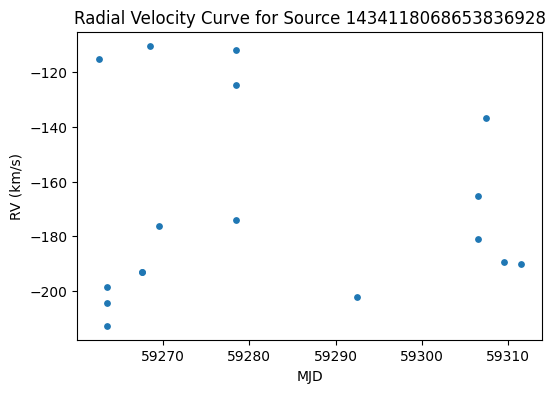

In [90]:
dates = filtered_df.loc[1434118068653836928, 'MJD'].to_numpy()

plt.figure(figsize=(6, 4))
plt.scatter(dates, rv_values, s=15)
plt.xlabel('MJD')
plt.ylabel('RV (km/s)')
plt.title('Radial Velocity Curve for Source 1434118068653836928')
plt.show()

Fitting Gaia Source 1434118068653836928


The period of Source 1434118068653836928 IS unimodal.
The Joker returned 1 posterior sample(s).


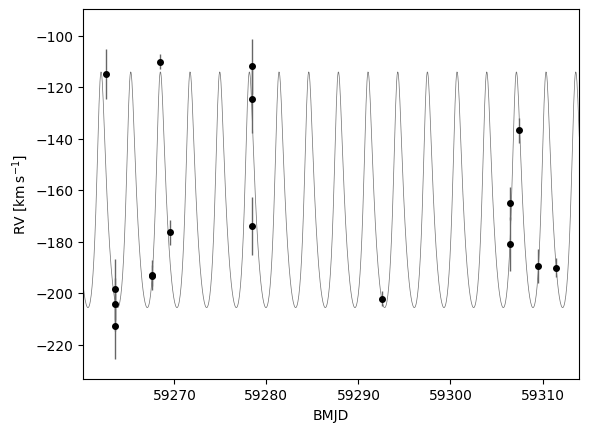

In [34]:
n_prior_samples = 1_000_000
max_posterior_samples = 512
source_id = 1434118068653836928

# initialise data
print(f"Fitting Gaia Source {source_id}")
t = Time(filtered_df.loc[source_id, "MJD"].values, format="mjd", scale="tcb")
rv = filtered_df.loc[source_id, "VRAD"].values * u.km / u.s
rv_err = filtered_df.loc[source_id, "VRAD_ERR"].values * u.km / u.s
data = tj.RVData(t=t, rv=rv, rv_err=rv_err)

# initialise prior
with pm.Model() as model:
    s = tj.units.with_unit(pm.Lognormal("s", -2, 1), u.km / u.s)
    prior = tj.JokerPrior.default(
        P_min=2 * u.day,
        P_max=1e5 * u.day, 
        sigma_K0=30 * u.km / u.s,
        sigma_v=100 * u.km / u.s,
        s=s,
    )

# sample prior
prior_samples = prior.sample(size=n_prior_samples, return_logprobs=True)

# run initial joker rejection sampling
with MultiPool(np.min([24, mp.cpu_count()])) as pool:
    joker = tj.TheJoker(prior, pool=pool)
    joker_samples = joker.rejection_sample(
        data,
        prior_samples,
        max_posterior_samples=max_posterior_samples,
        return_logprobs=True,
    )
is_P_unimodal = tj.is_P_unimodal(joker_samples, data)
print(
    f"The period of Source {source_id} {'is NOT' if not is_P_unimodal else 'IS'} unimodal."
)
print(f"The Joker returned {len(joker_samples.tbl)} posterior sample(s).")

# plot orbits
_ = tj.plot_rv_curves(joker_samples, data=data)


/var/folders/d9/12jjwmxs3z7bbz_6_9qsmh380000gn/T/ipykernel_56418/1639520629.py:23: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [__M0_m_omega_angle1, __M0_m_omega_angle2, __omega_angle1, __omega_angle2, s, e, P, K, v0]
INFO:pymc.sampling.mcmc:NUTS: [__M0_m_omega_angle1, __M0_m_omega_angle2, __omega_angle1, __omega_angle2, s, e, P, K, v0]


Output()

Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 852 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 852 seconds.


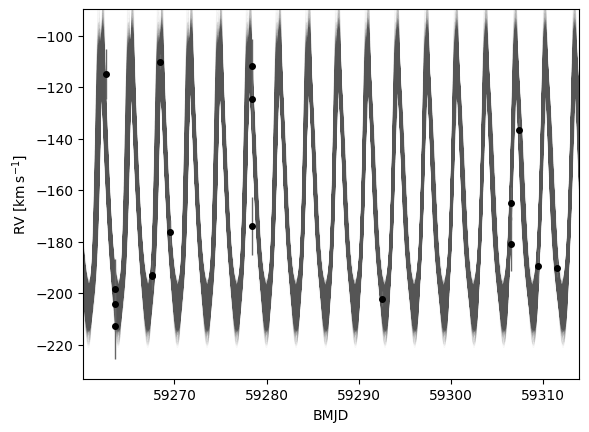

In [35]:
# run joker + NUTS sampling
with pm.Model():
    # set priors
    # we will sample in the parameters (M0 - omega, omega) instead of (M0, omega)
    M0_m_omega = tj.units.with_unit(angle("M0_m_omega"), u.radian)
    omega = tj.units.with_unit(angle("omega"), u.radian)
    M0 = tj.units.with_unit(pm.Deterministic("M0", M0_m_omega + omega), u.radian)
    s = tj.units.with_unit(pm.Lognormal("s", -2, 1), u.km / u.s)
    prior_mcmc = tj.JokerPrior.default(
        P_min=2 * u.day,
        P_max=1e5 * u.day,
        sigma_K0=30 * u.km / u.s,
        sigma_v=100 * u.km / u.s,
        s=s,
        pars={"M0": M0, "omega": omega},
    )

    # rejection sampling
    joker_mcmc = tj.TheJoker(prior_mcmc)

    # NUTS sampling
    mcmc_init = joker_mcmc.setup_mcmc(data, joker_samples)
    trace = pm.sample(
        tune=5000,
        draws=5000,
        start=mcmc_init,
        target_accept=0.99, #was 0.95
        cores=4,
        chains=4,
    )

# results
mcmc_samples = tj.JokerSamples.from_inference_data(prior, trace, data=data)
mcmc_samples = mcmc_samples.wrap_K()
samples_df = mcmc_samples.tbl.to_pandas()
_ = tj.plot_rv_curves(mcmc_samples, data=data)


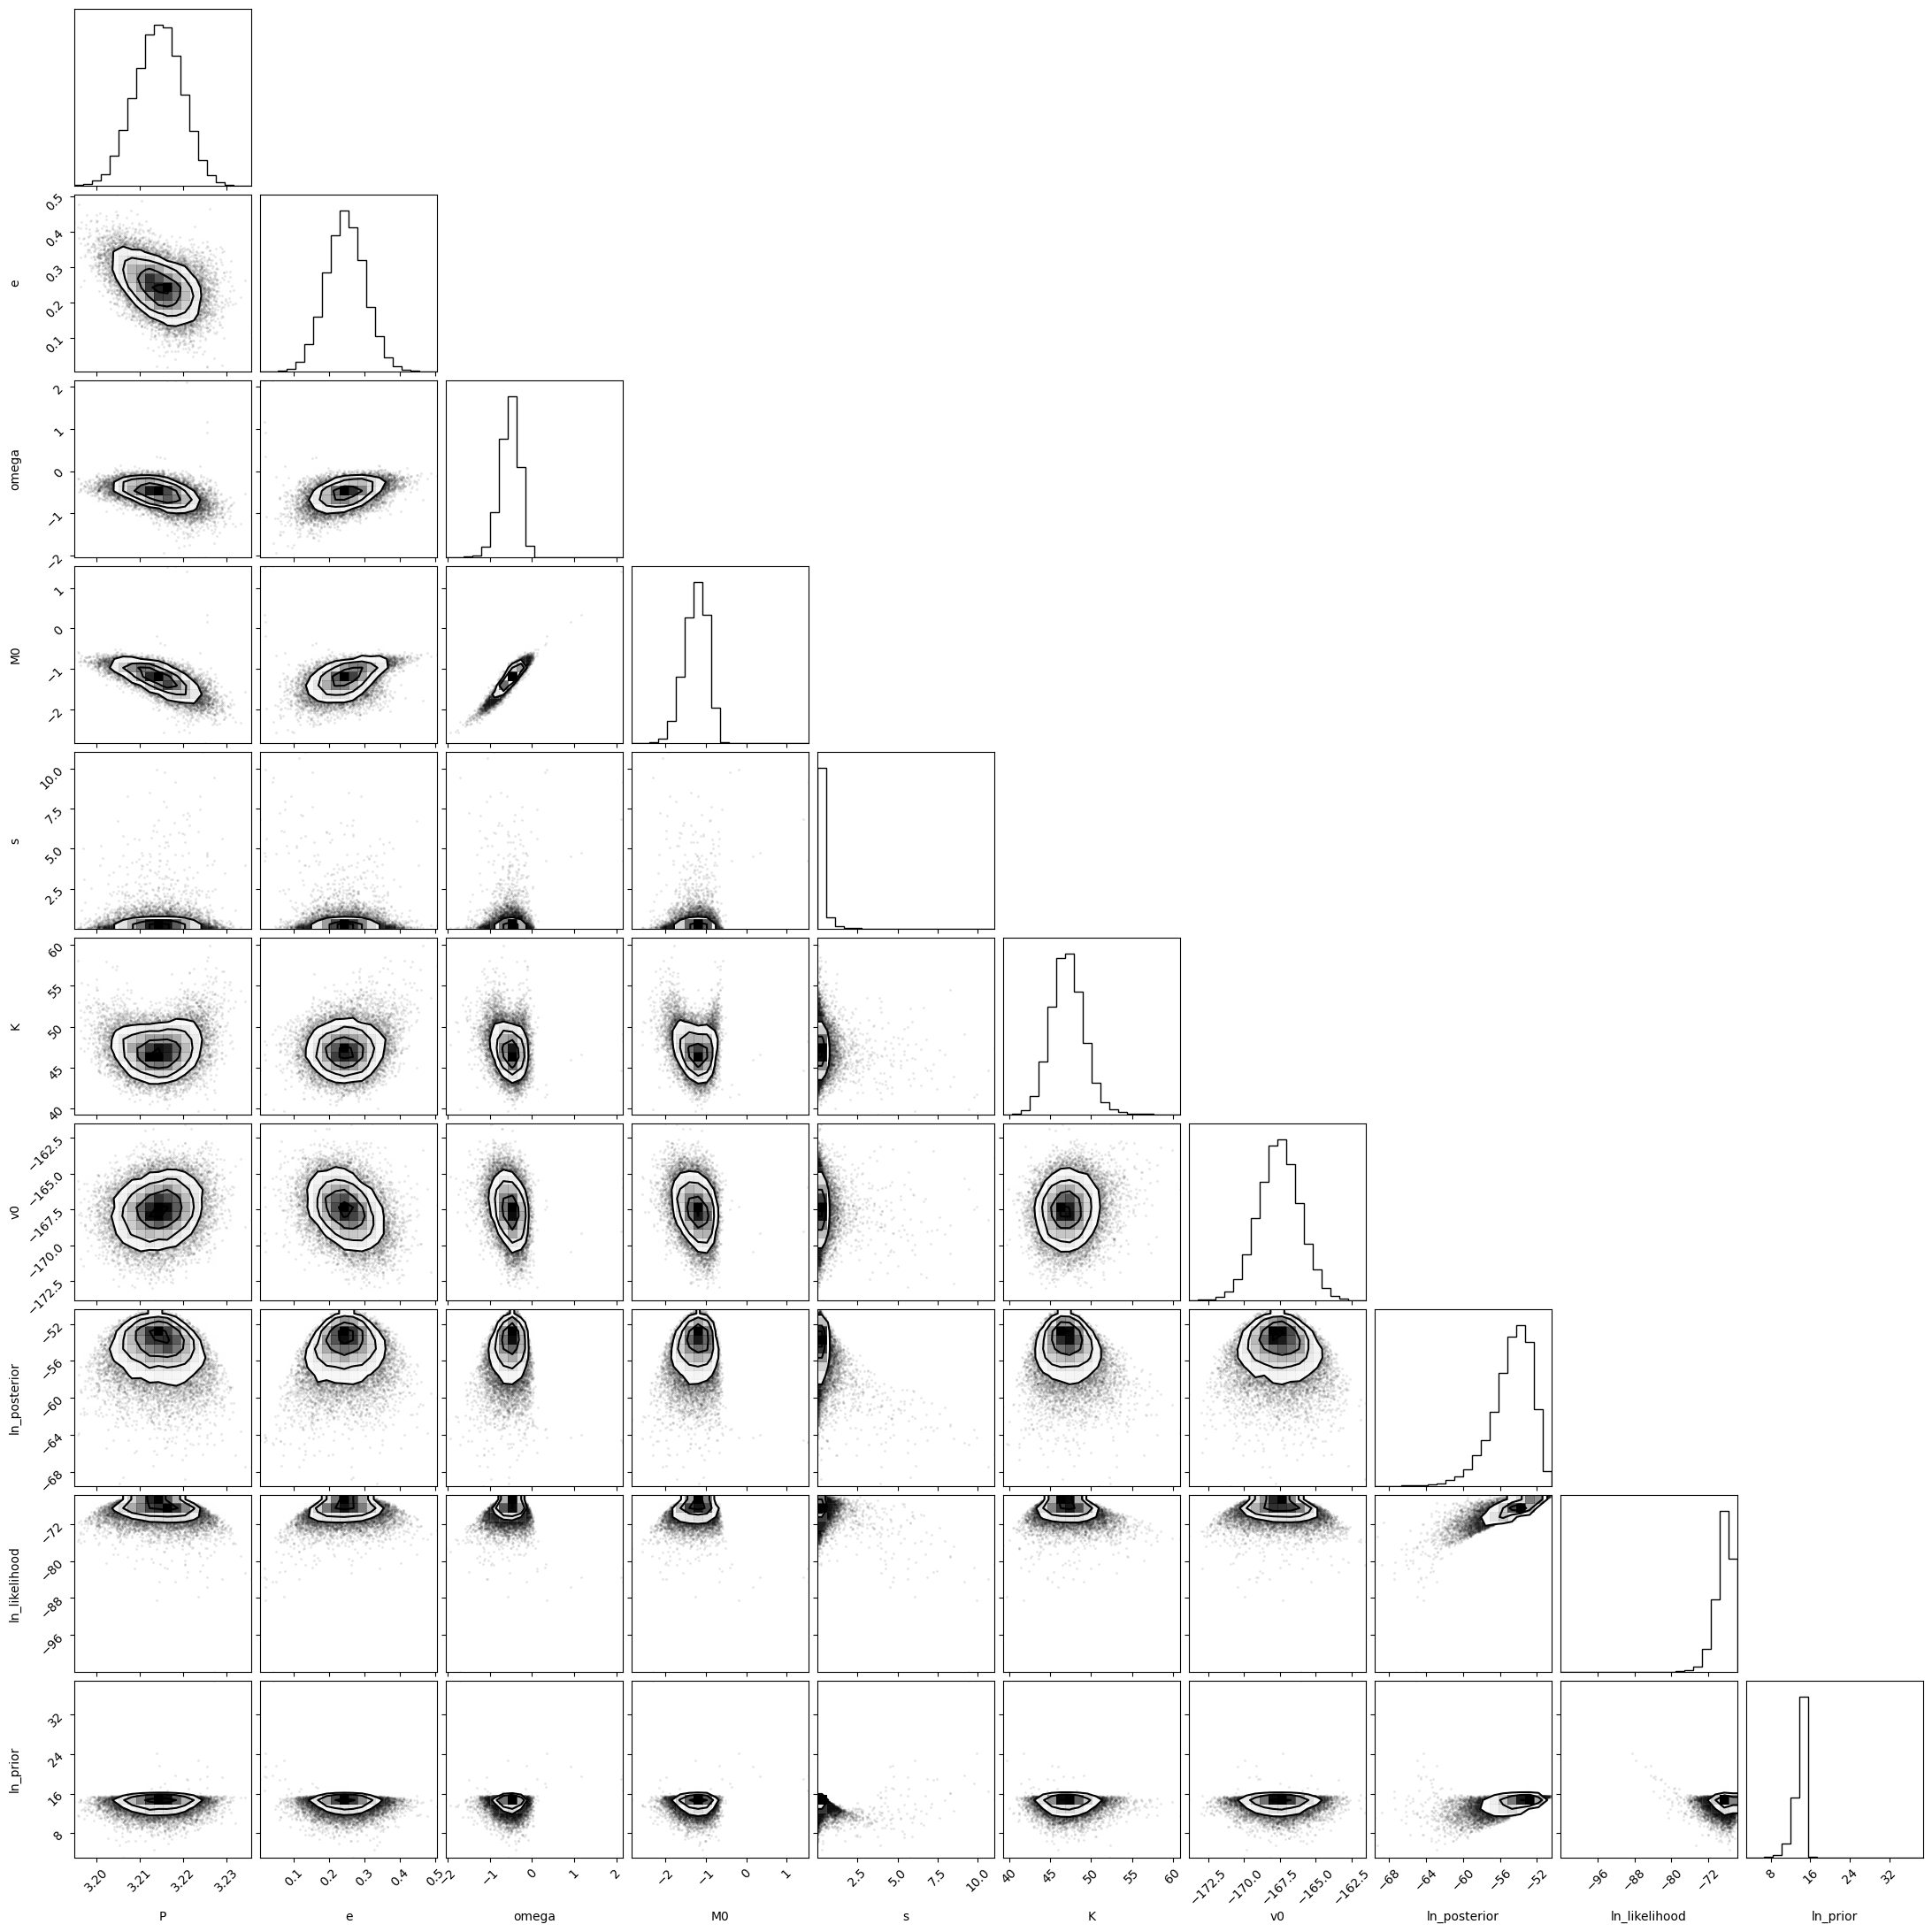

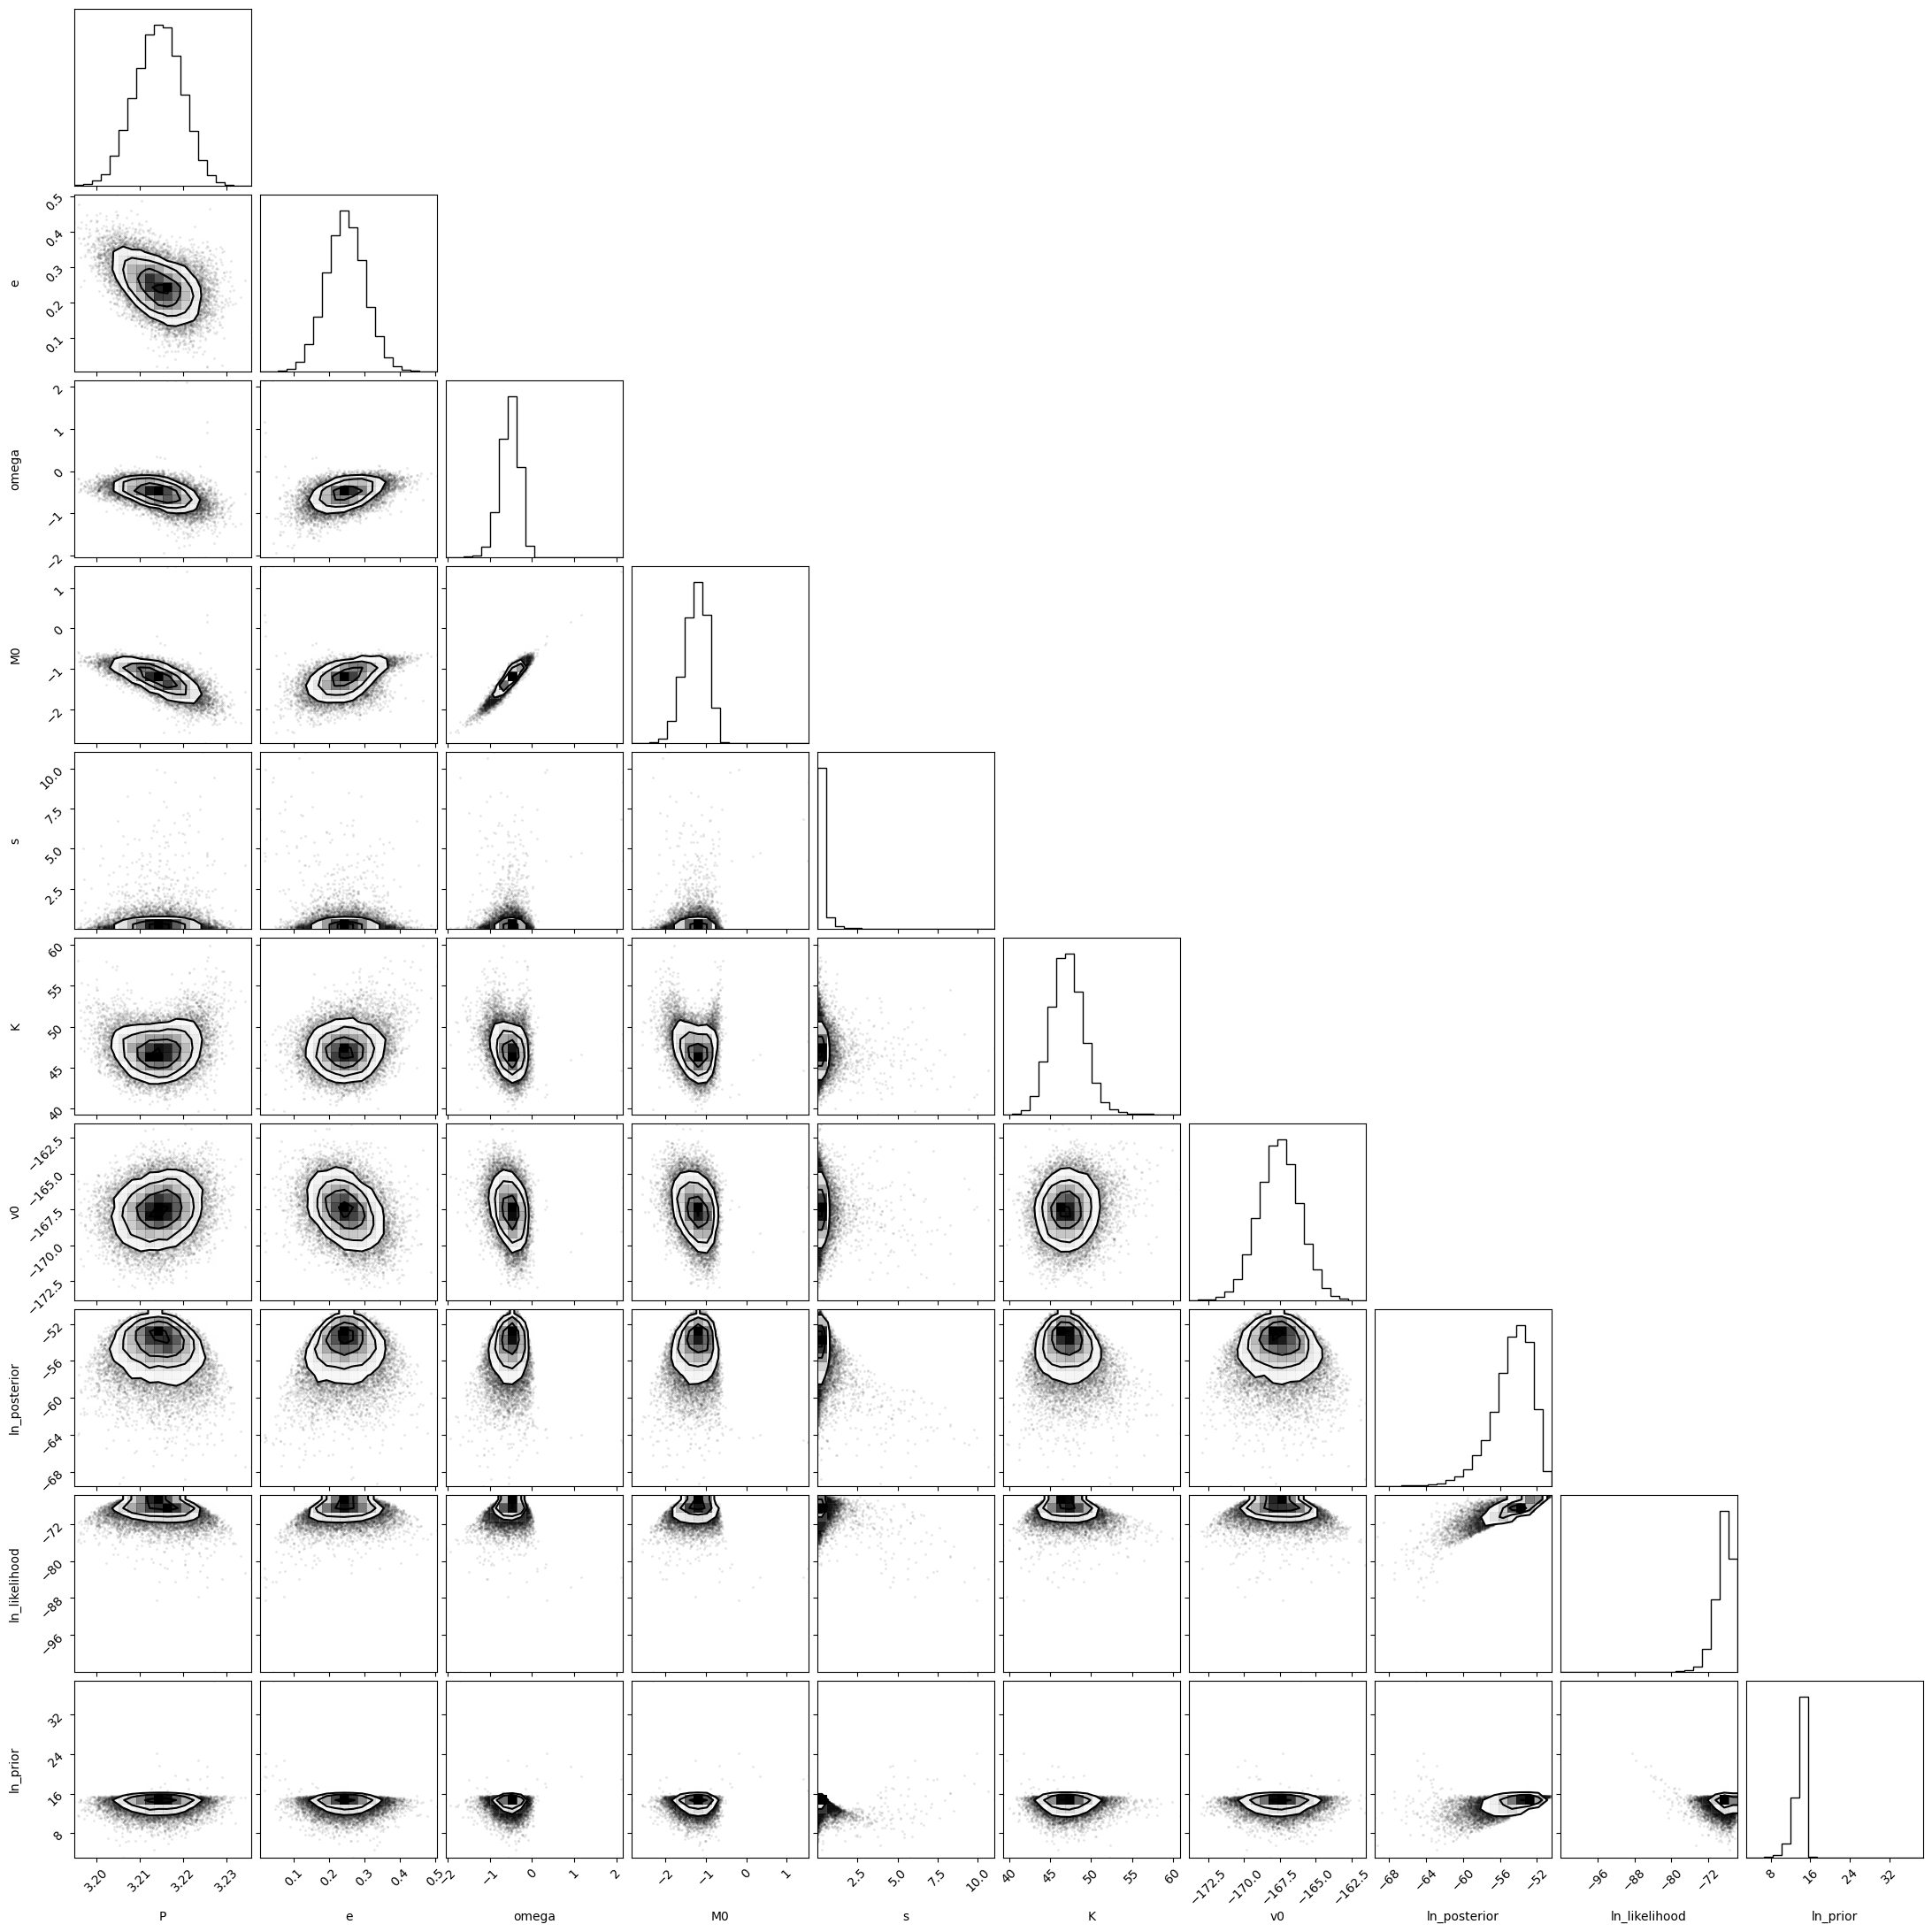

In [37]:
corner(samples_df, labels=[col for col in mcmc_samples.tbl.columns])


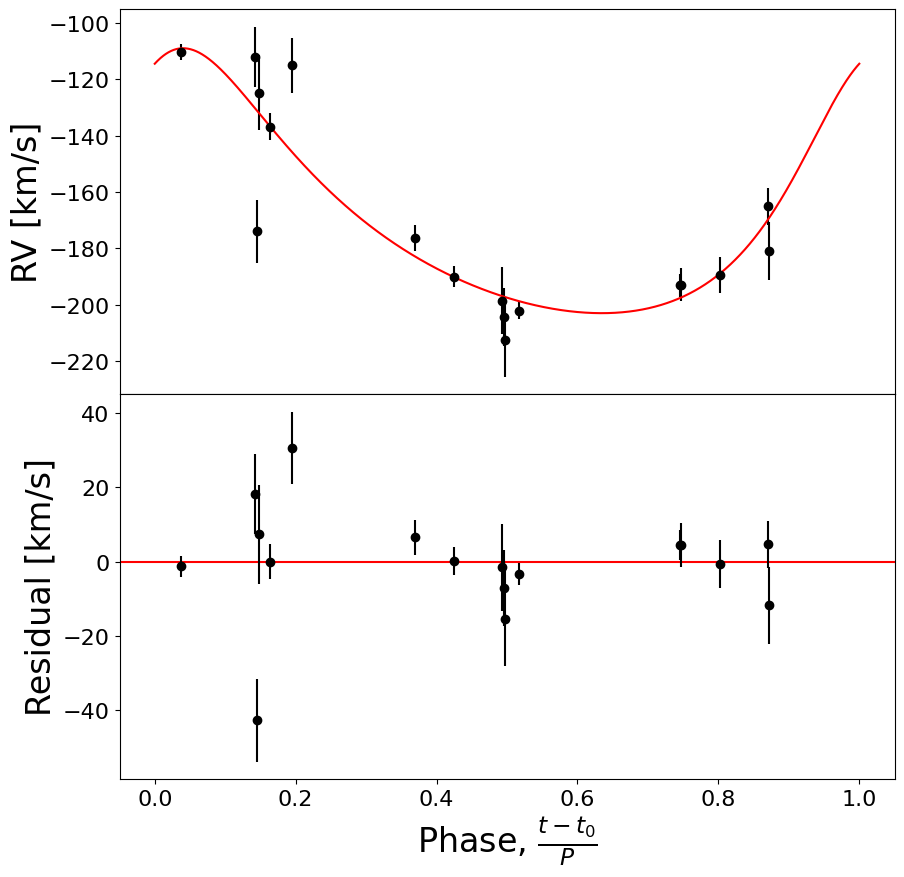

In [42]:
# plot phase-folded RV curve
plt.figure(figsize=(10, 10))
gs = GridSpec(2, 1)
gs.update(hspace=0)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[1, 0], sharex=ax1)

orbit = mcmc_samples.median_period().get_orbit()
P = orbit.P
t0 = mcmc_samples.median_period().get_t0()

_df = filtered_df[filtered_df["SOURCE_ID"] == source_id]

t = Time(_df["MJD"].values, format="mjd", scale="tcb")
rv = _df["VRAD"].values * u.km / u.s
rv_err = _df["VRAD_ERR"].values * u.km / u.s

phase = ((t - t0).tcb.jd * u.day / P) % 1

ax1.errorbar(
    phase,
    rv,
    yerr=rv_err,
    ls="",
    marker="o",
    ms=6,
    color="k",
    mec="k",
    mfc="black",
)

ax2.errorbar(
    phase,
    rv - orbit.radial_velocity(t),
    yerr=rv_err,
    ls="",
    marker="o",
    ms=6,
    color="k",
    mec="k",
    mfc="black",
)

unit_phase_grid = np.linspace(0, 1, 4096)
ax1.plot(
    unit_phase_grid,
    orbit.radial_velocity(t0 + P * unit_phase_grid).to_value(u.km / u.s),
    c="r",
)

ax2.axhline(0, c="r", zorder=0)

ax1.set_ylabel("RV [km/s]", fontsize=24)
ax2.set_ylabel("Residual [km/s]", fontsize=24)
ax2.set_xlabel(r"Phase, $\frac{t - t_0}{P}$", fontsize=24)
ax1.tick_params("x", labelsize=0)
ax1.tick_params("y", labelsize=16)
ax2.tick_params("both", labelsize=16)

plt.show()

In [87]:
# getting the values from the joker sample
posterior_df = joker_samples.tbl.to_pandas()

posterior_df

,P,e,omega,M0,s,K,v0,ln_likelihood,ln_prior.e,ln_prior.omega,ln_prior.M0,ln_prior.P,ln_prior.s,ln_prior.ln_prior
0,3.22354,0.262162,-0.343574,-1.1985,0.219571,45.810652,-171.172266,-80.070102,0.262162,-0.343574,-1.1985,3.22354,0.219571,-4.713449


In [97]:
# getting the values from the gaia table
query = """
select *
from gaiadr3.vari_eclipsing_binary
where source_id = 1434118068653836928
"""

job = Gaia.launch_job(query)
gaia_values = job.get_results()
gaia_values_df = gaia_values.to_pandas()

gaia_values_df

,solution_id,source_id,global_ranking,reference_time,frequency,frequency_error,geom_model_reference_level,geom_model_reference_level_error,geom_model_gaussian1_phase,geom_model_gaussian1_phase_error,geom_model_gaussian1_sigma,geom_model_gaussian1_sigma_error,geom_model_gaussian1_depth,geom_model_gaussian1_depth_error,geom_model_gaussian2_phase,geom_model_gaussian2_phase_error,geom_model_gaussian2_sigma,geom_model_gaussian2_sigma_error,geom_model_gaussian2_depth,geom_model_gaussian2_depth_error,geom_model_cosine_half_period_amplitude,geom_model_cosine_half_period_amplitude_error,geom_model_cosine_half_period_phase,geom_model_cosine_half_period_phase_error,model_type,num_model_parameters,reduced_chi2,derived_primary_ecl_phase,derived_primary_ecl_phase_error,derived_primary_ecl_duration,derived_primary_ecl_duration_error,derived_primary_ecl_depth,derived_primary_ecl_depth_error,derived_secondary_ecl_phase,derived_secondary_ecl_phase_error,derived_secondary_ecl_duration,derived_secondary_ecl_duration_error,derived_secondary_ecl_depth,derived_secondary_ecl_depth_error
0,375316653866487564,1434118068653836928,0.60666,2165.063022,2.517286,0.000012,17.61651,0.003772,0.243552,0.00737,0.057009,0.005221,0.45421,0.031111,0.72777,0.013067,0.072578,0.008239,0.144943,0.022112,NaN,NaN,NaN,NaN,TWOGAUSSIANS,8,2.78136,0.243552,0.00737,0.319252,0.029236,0.45404,0.031393,0.72777,0.013067,0.4,0.029369,0.144773,0.022132


In [100]:
# the orbital frequency is the inverse of the period
gaia_period = 1 / (gaia_values_df.loc[0, 'frequency'])
DESI_period = posterior_df.loc[0, 'P']

print(f"The period for this source reported in the GAIA catalog is: {gaia_period:.3f} days")
print(f"The period for this source calculated with DESI data is: {DESI_period:.2f} days")

The period for this source reported in the GAIA catalog is: 0.397 days
The period for this source calculated with DESI data is: 3.22 days
